In [121]:
import torch
import torch.nn as nn
from vgg import VGG
import data
import data_custom
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from utils.logger import Logger
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torchvision import transforms

In [173]:
_, _, fer2013 = data.get_dataloaders('./Datasets/FER2013', 32)
_, _, fer_plus = data.get_dataloaders('./Datasets/FERplus', 32)
_, _, custom_face_data = data_custom.get_dataloaders('./Datasets/CustomFaceData', 32)

In [ ]:
torch.cuda.empty_cache()


In [70]:
archs = {
    "VGG_11": ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)),
    "VGG_16": ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)),
}

In [71]:
vgg_11 = VGG(arch=archs['VGG_11'])
vgg_16 = VGG(arch=archs['VGG_16'])
vgg_16_pt = vgg16_bn()
vgg_16_pt.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=8, bias=True))

e:\Anaconda\TestML\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [72]:
datasets = {
    'FER2013': fer2013,
    'FERplus': fer_plus,
    'CustomFaceData': custom_face_data
}

In [ ]:
custom_face_data

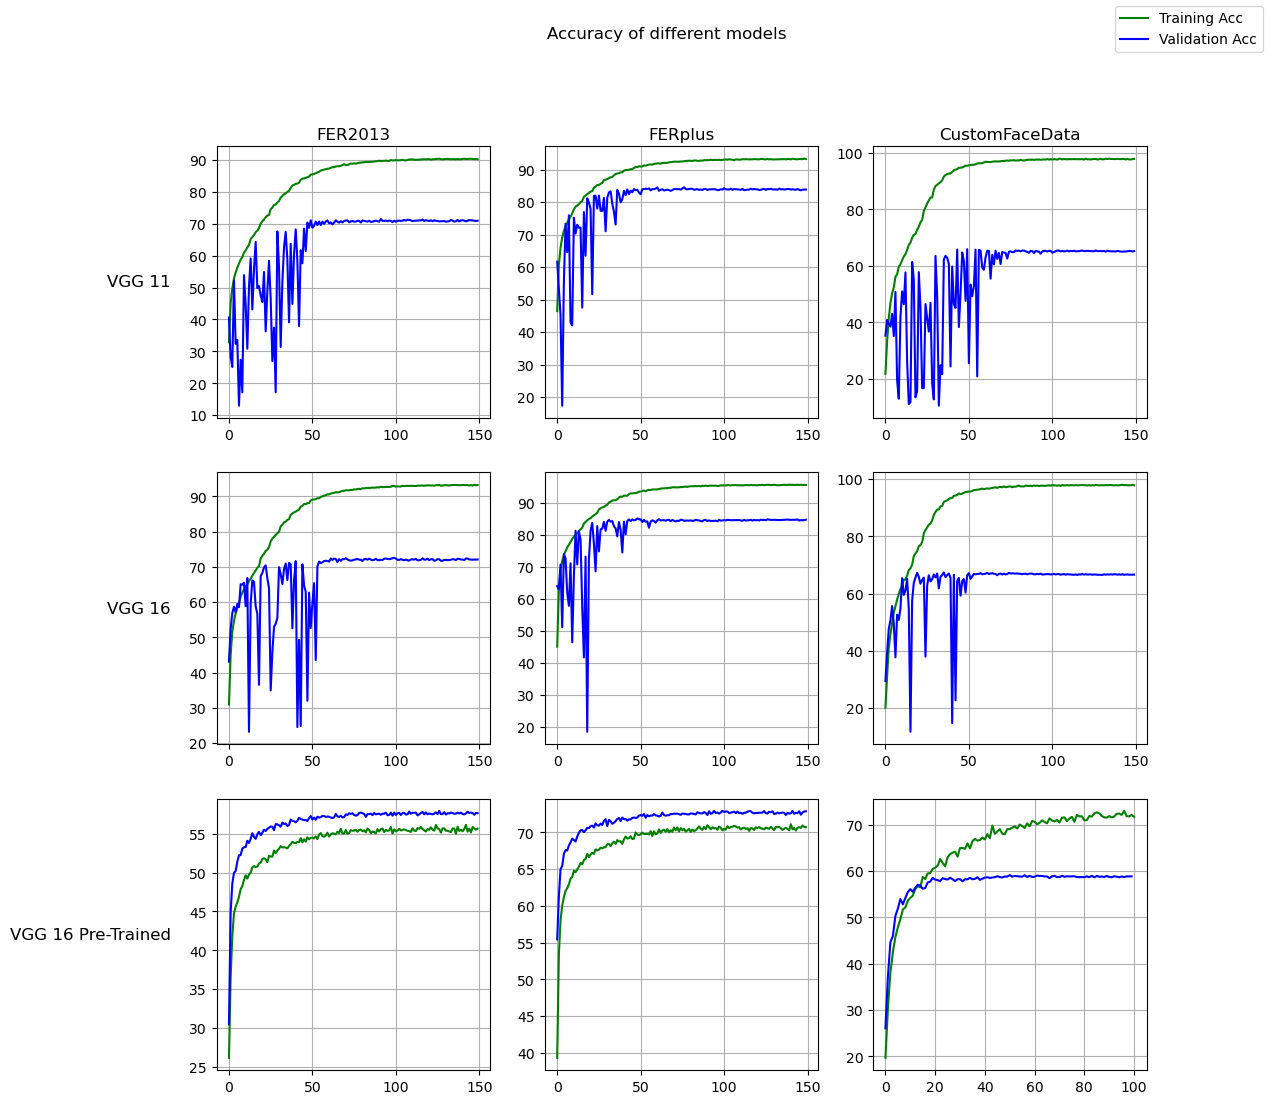

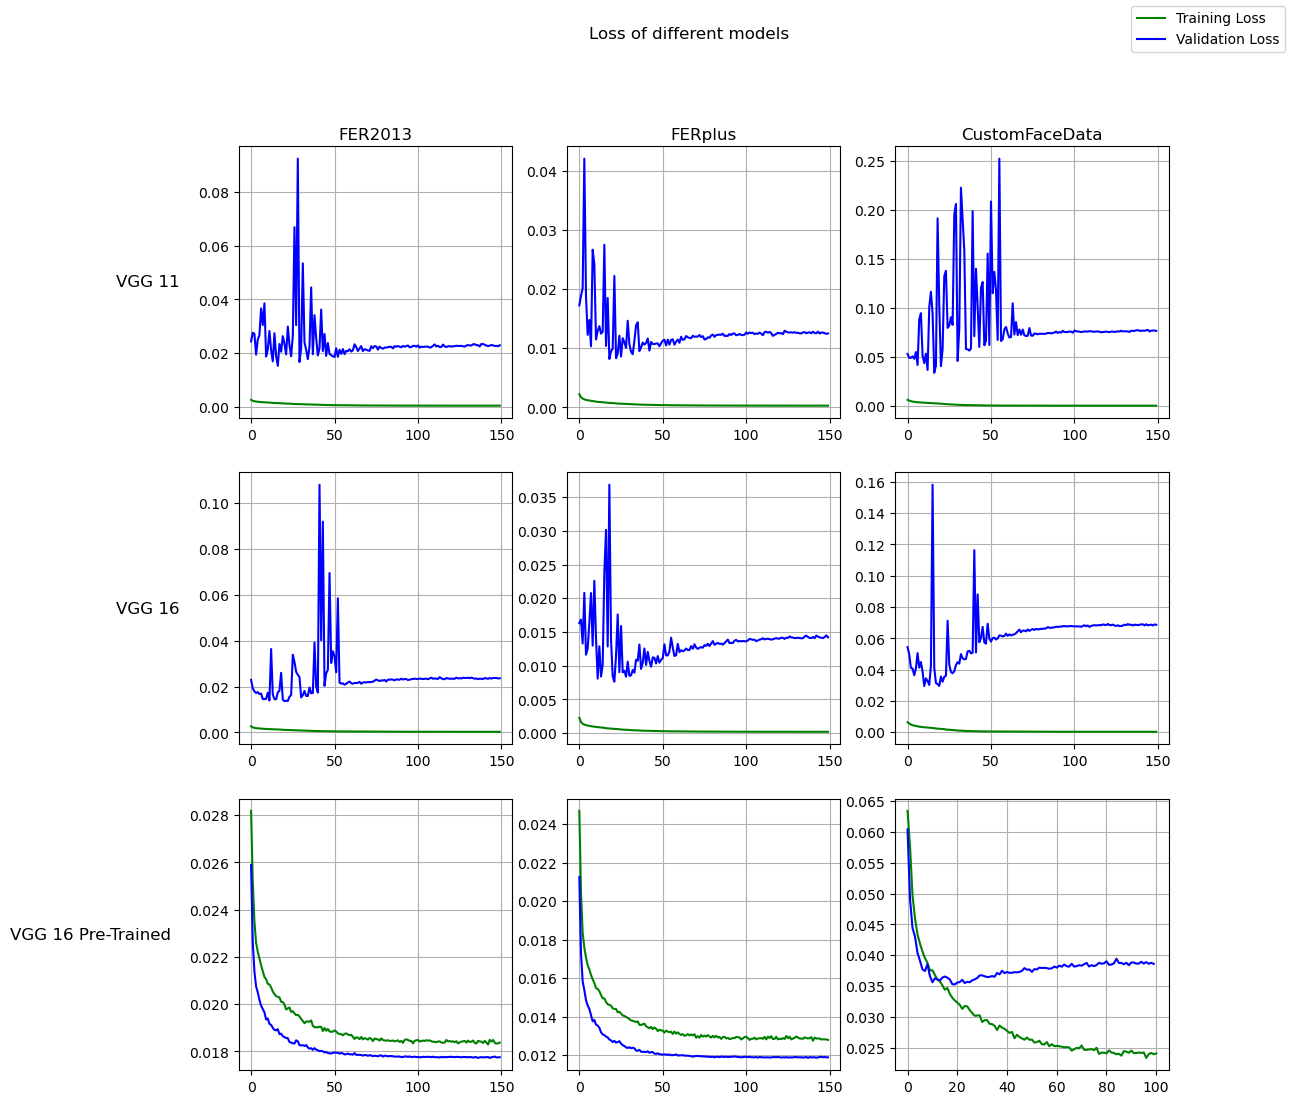

In [161]:
logger = Logger()

acc_plt = matplotlib.pyplot
loss_plt = matplotlib.pyplot

acc_fig, acc_axs = acc_plt.subplots(3, 3, figsize=(12, 12))
loss_fig, loss_axs = loss_plt.subplots(3, 3, figsize=(12, 12))

for ax, col in zip(acc_axs[0], datasets.keys()):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(acc_axs[:,0], ['VGG 11', "VGG 16", "VGG 16 Pre-Trained"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    

for ax, col in zip(loss_axs[0], datasets.keys()):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(loss_axs[:,0], ['VGG 11', "VGG 16", "VGG 16 Pre-Trained"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

model_names = ['VGG_11', 'VGG_16', 'VGG_16_PT']
for i, dataset in enumerate(datasets):
    for j in range(len(model_names)):
        name = model_names[j]
        # net = VGG(arch=archs[name]) if j != 2 else vgg_16_pt
        path = f'./checkpoints/{name}_{dataset}/epoch_150'
        checkpoint = torch.load(path)
        # net.load_state_dict(checkpoint["params"])
        logger.restore_logs(checkpoint['logs'])

        acc_axs[j,i].plot(logger.acc_train, 'g', label='Training Acc')
        acc_axs[j,i].plot(logger.acc_val, 'b', label='Validation Acc')
        acc_axs[j,i].grid()

        loss_axs[j,i].plot(logger.loss_train, 'g', label='Training Loss')
        loss_axs[j,i].plot(logger.loss_val, 'b', label='Validation Loss')
        loss_axs[j,i].grid()


acc_fig.suptitle('Accuracy of different models')
handles, labels = acc_axs[0,0].get_legend_handles_labels()
acc_fig.legend(handles, labels)

loss_fig.suptitle('Loss of different models')
handles, labels = loss_axs[0,0].get_legend_handles_labels()
loss_fig.legend(handles, labels)

acc_plt.show()
loss_plt.show()

In [108]:
y_tests = []
y_preds = []

model_names = ['VGG_11', 'VGG_16', 'VGG_16_PT']

for i in range(2,len(model_names)):
    if i == 2:
        weights = VGG16_BN_Weights.DEFAULT
        preprocess = weights.transforms()
        for dataset in datasets:
            datasets[dataset].dataset.transform =  transforms.Compose([
            transforms.Lambda(lambda x: x.convert("RGB")),
            preprocess,])

    for j, dataset in enumerate(datasets):
        name = model_names[i]
        net = VGG(arch=archs[name]) if i != 2 else vgg_16_pt
        path = f'./checkpoints/{name}_{dataset}/epoch_150'
        checkpoint = torch.load(path)
        net.load_state_dict(checkpoint["params"])
        logger.restore_logs(checkpoint['logs'])

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        net = net.eval()
        net.to(device)

        y_pred = []
        y_test = []

        with torch.no_grad():

            for inputs, labels in datasets[dataset]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                if i != 2:
                    # fuse crops and batchsize
                    original_shape = inputs.shape
                    inputs = inputs.view(-1, *inputs.shape[-3:])

                    # forward
                    outputs = net(inputs)

                    # combine results across the crops
                    outputs = outputs.view(*original_shape[:2], -1)
                    outputs = torch.sum(outputs, dim=1) / original_shape[1]
                else:
                    outputs = net(inputs)
                _, preds = torch.max(outputs.data, 1)
                y_test.extend(labels.tolist())
                y_pred.extend(preds.tolist())

        y_tests.append(y_test)
        y_preds.append(y_pred)
        print(model_names[i], dataset)

VGG_16_PT FER2013
VGG_16_PT FERplus
VGG_16_PT CustomFaceData


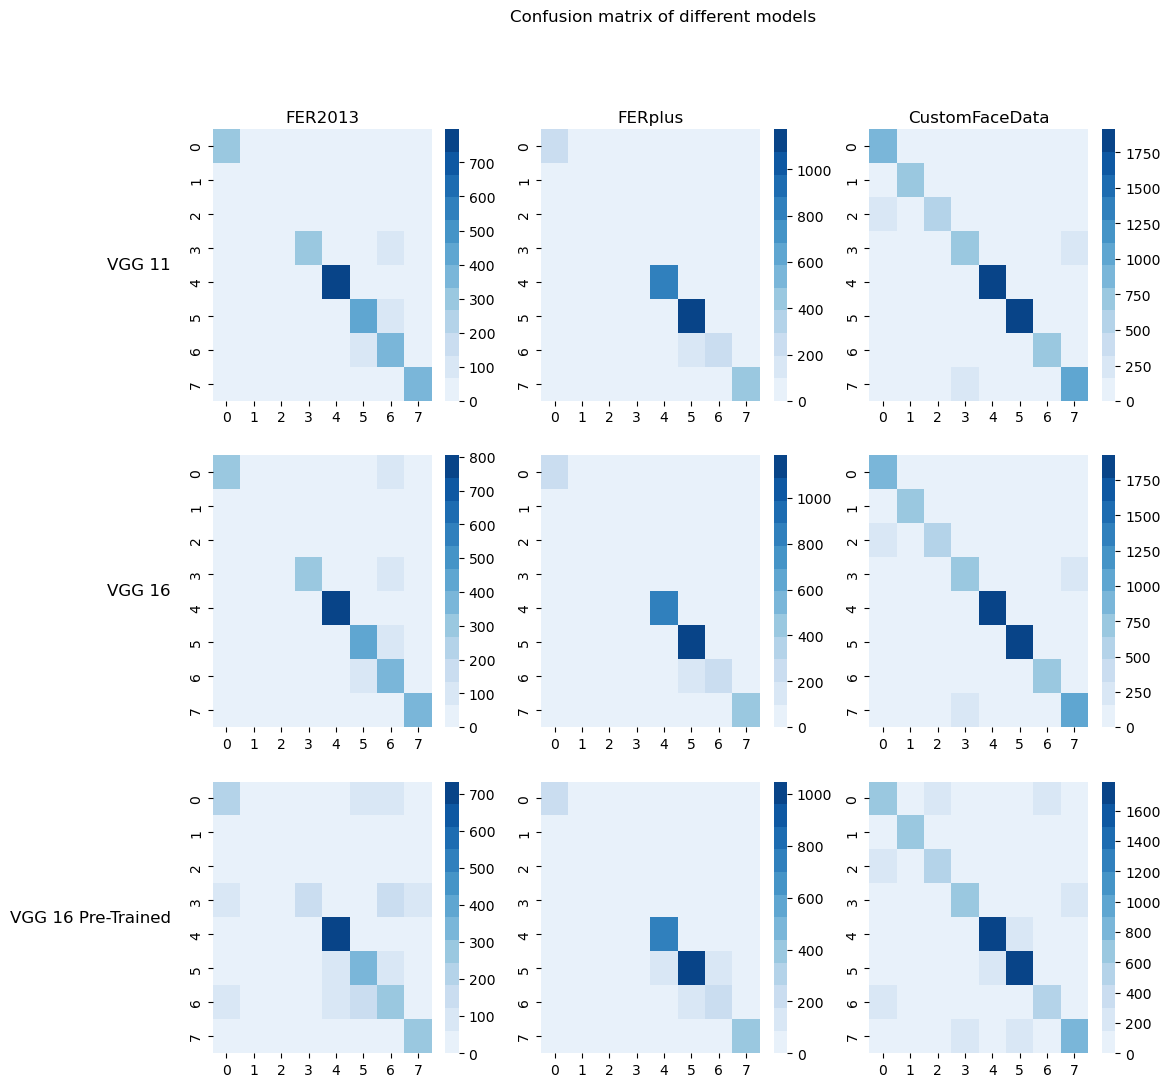

In [119]:
plt = matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for ax, col in zip(axs[0], datasets.keys()):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], ['VGG 11', "VGG 16", "VGG 16 Pre-Trained"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for i in range(len(y_tests)):
    cm = confusion_matrix(y_tests[i], y_preds[i], labels = [0,1,2,3,4,5,6,7])
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, ax = axs[i//3,i%3], cmap = sns.color_palette("Blues",12))
             

fig.suptitle('Confusion matrix of different models')
plt.show()


In [159]:
f1_scores = np.zeros((3,3))
acc_scores = np.zeros((3,3))
for i in range(len(y_tests)):
    f1_scores[i//3,i%3] = f1_score(y_tests[i], y_preds[i], average='macro')
    acc_scores[i//3,i%3] = accuracy_score(y_tests[i], y_preds[i])
f1_scores = f1_scores.round(decimals = 2)
acc_scores = acc_scores.round(decimals = 2)

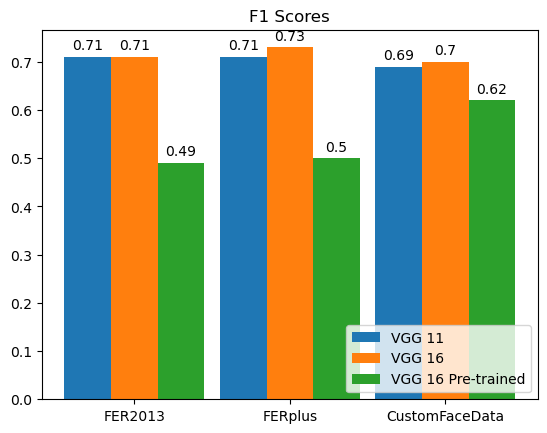

In [157]:
plt = matplotlib.pyplot

names = ['VGG 11', 'VGG 16', 'VGG 16 Pre-trained']
datas = ['FER2013', 'FERplus', 'CustomFaceData']

X_axis = np.arange(3)
for i in range(3):
    rects = plt.bar(X_axis + i*0.3 , f1_scores[i, :], 0.3, label = names[i])
    plt.bar_label(rects, padding=3)
plt.legend(loc = 'lower right')
plt.xticks(X_axis + 0.3, datas)
plt.title('F1 Scores')
plt.show()


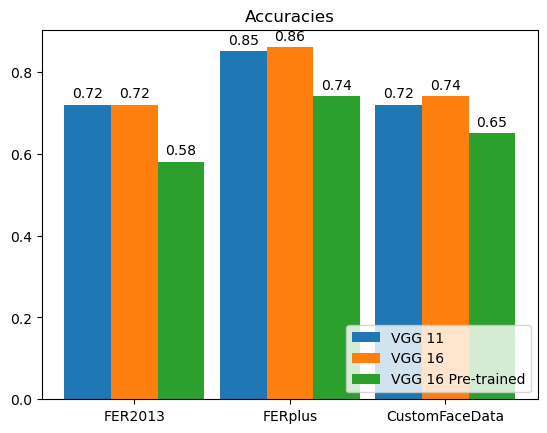

In [160]:
plt = matplotlib.pyplot

names = ['VGG 11', 'VGG 16', 'VGG 16 Pre-trained']
datas = ['FER2013', 'FERplus', 'CustomFaceData']

X_axis = np.arange(3)
for i in range(3):
    rects = plt.bar(X_axis + i*0.3 , acc_scores[i, :], 0.3, label = names[i])
    plt.bar_label(rects, padding=3)
plt.legend(loc = 'lower right')
plt.xticks(X_axis + 0.3, datas)
plt.title('Accuracies')
plt.show()